# ResNet18 Fine-Tuning and Feature Extraction

This notebook processes geospatial Image Tiles for each DHS cluster through ResNet18, extracts features from convolutional layers, and projects them using UMAP. The UMAP projections are then processed through a clustering algorithm to identify and quantify the clusters. 

## File System Structure

## Input

The input GeoTiff files for each data type (for each DHS location) are loacted in `Image_Tiles` within the hierarchy below. 

<pre style="font-family: monospace;">
./GIS-Image-Stack-Processing
    /AOI/
        PK/
            Image_Tiles/
                Nightlights/
                   # Cropped image tiles at each DHS cluster location.
                    PK_1_C-1_Nightlights_2022_400m.tif
                    PK_2_C-2_Nightlights_2022_400m.tif
                    :
                    PK_560_C-580_Nightlights_2022_400m.tif
                
                Population/
                    PK_1_C-1_Population_2022_400m.tif
                    :
                
                Rainfall/
                    PK_1_C-1_Rainfall_2001-2022_400m.tif
                    :
</pre>


## Required Configurations

The following configurations are required for each execution of this notebook: the two-letter country code. Other model and feature extraction configurations are available in the Configuraton section.
<pre style="font-family: monospace;">
<span style="color: blue;">country_code  = 'PK'</span>      # Set the country code to one of the available AOIs in the list below

Available AOIs: AM (Armenia)
                MA (Morocco)
                MB (Moldova)
                ML (Mali)
                MR (Mauritania)
                NI (Niger)
                PK (Pakistan)
                SN (Senegal)
                TD (Chad)
</pre>

In [1]:
#-------------------------------------------------
# REQUIRED CONFIGURATIONS HERE
#-------------------------------------------------
country_code  = 'PK'     # Set the country code
#-------------------------------------------------

In [2]:
import os
import time
import sys
import re
import copy
import rasterio
import numpy as np
import math
import random
import warnings
import json
import tempfile
from enum import Enum
from collections import Counter
from functools import partial

import gc
import torch
import torch.nn as nn
import torch.nn.functional as TF 
import torchvision.transforms.functional as F

from torch import optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

from torchvision.transforms.functional import to_pil_image

from typing import Optional, List, Tuple, Union
from tqdm import tqdm

import tqdm as notebook_tqdm

import seaborn as sns
import pandas as pd
import geopandas as gpd
import umap

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from mpl_toolkits.mplot3d import Axes3D

from bokeh.transform import factor_cmap
from bokeh.palettes import Category10
from bokeh.io import output_notebook
from bokeh.palettes import Viridis256

import umap.umap_ as umap

from dataclasses import dataclass, field

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from io import BytesIO
from PIL import Image


bold = f"\033[1m"
reset = f"\033[0m"

output_notebook()

# Allows plots to display in notebook from packages
%matplotlib inline  

Loading BokehJS ...

In [3]:
# Set default num_workers
num_workers = 0

# Detect the OS name
os_name = os.popen('uname').read().strip()

# Check if the OS is Linux
if os_name == "Linux":
    
    print("Running on Linux. Setting num_workers to 64.")
    num_workers = 64
  
    print("Setting OS environment paths...")

    # Set CUDA_HOME to the conda environment prefix
    os.environ['CUDA_HOME'] = os.getenv('CONDA_PREFIX')

    # Update PATH to include the CUDA bin directory
    os.environ['PATH'] = os.path.join(os.getenv('CUDA_HOME'), 'bin') + ':' + os.getenv('PATH')

    # Update LD_LIBRARY_PATH to include the CUDA lib64 directory, handling the case where it's None
    ld_library_path = os.getenv('LD_LIBRARY_PATH')
    if ld_library_path is None:
        os.environ['LD_LIBRARY_PATH'] = os.path.join(os.getenv('CUDA_HOME'), 'lib64')
    else:
        os.environ['LD_LIBRARY_PATH'] = os.path.join(os.getenv('CUDA_HOME'), 'lib64') + ':' + ld_library_path

    # Set the environment variable for PyTorch CUDA memory allocation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [4]:
sys.path.append('./GIS-Image-Stack-Processing')  # Adjust path if `gist_utils` is moved

cache_dir = 'project_utils/__pycache__'
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    
# Import module that contains several convenience functions (e.g., gdal wrappers)
from project_utils import *
from project_utils.resnet_utils import *
from project_utils.plot_utils import *
from project_utils.aoi_configurations import aoi_configurations

os.environ['PATH'] += os.pathsep + '/usr/local/bin/chromedriver'


## System Configuration

In [5]:
def system_config(SEED_VALUE=42):
    """
    Configures the system environment for PyTorch-based operations.

    Args:
        SEED_VALUE (int): Seed value for random number generation. 
        package_list (str): String containing a list of additional packages to install  
        for Google Colab or Kaggle. 

    Returns:
        tuple: A tuple containing the device name as a string and a boolean indicating GPU availability.
    """

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    def is_running_in_colab():
        return 'COLAB_GPU' in os.environ
        
    def is_running_in_kaggle():
        return 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

    #--------------------------------
    # Check for availability of GPUs. 
    #--------------------------------
    if torch.cuda.is_available():
        print('Using CUDA GPU')
        
        # Set the device to the first CUDA device.
        DEVICE = torch.device('cuda')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = True

        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)

        # Performance and deterministic behavior.
        torch.backends.cudnn.enabled = True       # Provides highly optimized primitives for DL operations.
        torch.backends.cudnn.deterministic = False 
        torch.backends.cudnn.benchmark = False    # Setting to True can cause non-deterministic behavior.
        
    else:
        
        print('Using CPU')
        DEVICE = torch.device('cpu')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = False
        
        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}
            print('Note: Change runtime type to GPU for better performance.')
        
        torch.use_deterministic_algorithms(True)

    return str(DEVICE), GPU_AVAILABLE

In [6]:
DEVICE, GPU_AVAILABLE = system_config()

if DEVICE == 'cuda':
    torch.cuda.empty_cache()
    !nvidia-smi

Using CPU
Device:  cpu


## Configurations

In [7]:
# Color map for clsuters (should not be edited as the color order has been standardized)
cluster_colors = ['blue', 'red', 'green', 'purple', 'orange', 'hotpink', 'navy']
symbol_size = 8

In [8]:
class TargetType(Enum):
    FRACTION_DPT3_VACCINATED  = "fraction_dpt3_vaccinated"
    FRACTION_WITH_ELECTRICITY = "fraction_with_electricity"
    FRACTION_WITH_FRESH_WATER = "fraction_with_fresh_water"
    MEAN_WEALTH_INDEX         = "mean_wealth_index"
    FRACTION_WITH_RADIO       = "fraction_with_radio"
    FRACTION_WITH_TV          = "fraction_with_tv"
    
    
target_name_mapping = {
    TargetType.FRACTION_DPT3_VACCINATED:  "Fraction DPT3 Vaccinated",
    TargetType.FRACTION_WITH_ELECTRICITY: "Fraction with Electricity",
    TargetType.FRACTION_WITH_FRESH_WATER: "Fraction with Fresh Water",
    TargetType.MEAN_WEALTH_INDEX:         "Mean Wealth Index",
    TargetType.FRACTION_WITH_RADIO:       "Fraction with Radio",
    TargetType.FRACTION_WITH_TV:          "Fraction with TV",
}

class ModelMode(Enum):
    PRE_TRAINED = "Pre_Trained"
    FINE_TUNE   = "Fine_Tune"
    CHECKPOINT  = "Checkpoint"
    
# Dataset configuration parameters
@dataclass(frozen=True)
class DatasetConfig:
    COUNTRY_CODE:     str  
    IMG_HEIGHT:       int = 224
    IMG_WIDTH:        int = 224
    GIS_ROOT:         str = './GIS-Image-Stack-Processing'
    AOI_ROOT:         str = './GIS-Image-Stack-Processing/AOI/'
    PRT_ROOT:         str = './GIS-Image-Stack-Processing/AOI/Partitions'
    TARGET_TYPE:      Union[TargetType, List[TargetType]] = TargetType.FRACTION_WITH_FRESH_WATER

@dataclass(frozen=True)
class FeatureConfig:
    FEATURE_LAYER:   str = 'layer4'
    BLOCK_INDEX:     int = 1
    SUB_LAYER_PART:  str = 'conv2'
    RELU:            bool = True        # Set to True to extract featuers from last (ReLU) in layer.
                                        # Ignores BLOCK_INDEX and SUB_LAYER_PART
@dataclass(frozen=True)
class TrainingConfig:
    OUTPUTS:          int  
    VERBOSE:          bool  = True
    EPOCHS:           int   = 51
    LEARNING_RATE:    float = .00004
    BATCH_SIZE:       int   = 8
    L2_REG:           float = .02
    DROPOUT:          float = .4
    PATIENCE:         int   = 10
    NUM_WORKERS:      int   = num_workers
    FINE_TUNE_LAYERS: int   = 4
    USE_DATA_AUG:     bool  = True
    USE_LOG1P:        bool  = True
    MODEL_MODE:       ModelMode = ModelMode.CHECKPOINT  # Specify the type of model
    LOG_DIR:          str   = "./ResNet18_LOGS_DATA"
    CHECKPOINT_DIR:   str   = "./ResNet18_CHECKPOINTS"
    CASE_STRING:      str   = "9AOI"                    # Optional: Additional case string 
    
    # 9 AOI Values
    MEAN_STD: dict = field(default_factory=lambda: {
        'Nightlights': (0.4051, 0.3869),
        'Population':  (1.5032, 2.2611),
        'Rainfall':    (1.4170, 0.8373)
    })

    def get_checkpoint_file(self, training_string: str = "") -> str:
        case_str = training_string if training_string else self.CASE_STRING
        return f"ResNet18_{self.FINE_TUNE_LAYERS}layers_{self.OUTPUTS}targets_{case_str}.pth"
    
    @staticmethod
    def from_dataset_config(dataset_config: DatasetConfig):
        if isinstance(dataset_config.TARGET_TYPE, list):
            num_targets =  len(dataset_config.TARGET_TYPE)
        else:
            num_targets = 1
        return  TrainingConfig(OUTPUTS=num_targets)


# Result configurations
@dataclass(frozen=True)
class ResultsConfig:
    COMPUTE_GEOSPATIAL:  bool = True
    COMPUTE_AOI_DIST:    bool = False  # Takes time when set to True
    PLOT_TRAINING_DIR:    str = './Plots_Fine_Tuning'
    PLOT_UMAP_FEAT_DIR:   str = './Plots_Projected_Features/9AOI'
    PLOT_GEOSPATIAL_DIR:  str = './Plots_Geospatial/9AOI'

In [9]:
#------------------------------------
# Provided for conveninet refernece
#------------------------------------
# ├─Sequential (layer3)                    [1, 256, 14, 14]          --
# │    └─BasicBlock (0)                    [1, 256, 14, 14]          --
# │    │    └─Conv2d (conv1)               [1, 256, 14, 14]          (294,912)
# │    │    └─BatchNorm2d (bn1)            [1, 256, 14, 14]          (512)
# │    │    └─ReLU (relu)                  [1, 256, 14, 14]          --
# │    │    └─Conv2d (conv2)               [1, 256, 14, 14]          (589,824)
# │    │    └─BatchNorm2d (bn2)            [1, 256, 14, 14]          (512)
# │    │    └─Sequential (downsample)      [1, 256, 14, 14]          (33,280)
# │    │    └─ReLU (relu)                  [1, 256, 14, 14]          --
# │    └─BasicBlock (1)                    [1, 256, 14, 14]          --
# │    │    └─Conv2d (conv1)               [1, 256, 14, 14]          (589,824)
# │    │    └─BatchNorm2d (bn1)            [1, 256, 14, 14]          (512)
# │    │    └─ReLU (relu)                  [1, 256, 14, 14]          --
# │    │    └─Conv2d (conv2)               [1, 256, 14, 14]          (589,824)
# │    │    └─BatchNorm2d (bn2)            [1, 256, 14, 14]          (512)
# │    │    └─ReLU (relu)                  [1, 256, 14, 14]          --
# ├─Sequential (layer4)                    [1, 512, 7, 7]            --
# │    └─BasicBlock (0)                    [1, 512, 7, 7]            --
# │    │    └─Conv2d (conv1)               [1, 512, 7, 7]            (1,179,648)
# │    │    └─BatchNorm2d (bn1)            [1, 512, 7, 7]            (1,024)
# │    │    └─ReLU (relu)                  [1, 512, 7, 7]            --
# │    │    └─Conv2d (conv2)               [1, 512, 7, 7]            (2,359,296)
# │    │    └─BatchNorm2d (bn2)            [1, 512, 7, 7]            (1,024)
# │    │    └─Sequential (downsample)      [1, 512, 7, 7]            (132,096)
# │    │    └─ReLU (relu)                  [1, 512, 7, 7]            --
# │    └─BasicBlock (1)                    [1, 512, 7, 7]            --
# │    │    └─Conv2d (conv1)               [1, 512, 7, 7]            (2,359,296)
# │    │    └─BatchNorm2d (bn1)            [1, 512, 7, 7]            (1,024)
# │    │    └─ReLU (relu)                  [1, 512, 7, 7]            --
# │    │    └─Conv2d (conv2)               [1, 512, 7, 7]            (2,359,296)
# │    │    └─BatchNorm2d (bn2)            [1, 512, 7, 7]            (1,024)
# │    │    └─ReLU (relu)                  [1, 512, 7, 7]            --

In [10]:
#---------------------------------------------------------------------------------   
# Multiple Regression
# dataset_config = DatasetConfig(COUNTRY_CODE=country_code,
#                               TARGET_TYPE=[TargetType.FRACTION_DPT3_VACCINATED,
#                                            TargetType.FRACTION_WITH_ELECTRICITY,
#                                            TargetType.FRACTION_WITH_FRESH_WATER,
#                                            TargetType.MEAN_WEALTH_INDEX,
#                                            TargetType.FRACTION_WITH_RADIO,
#                                            TargetType.FRACTION_WITH_TV])

dataset_config = DatasetConfig(COUNTRY_CODE=country_code,
                              TARGET_TYPE=[TargetType.FRACTION_DPT3_VACCINATED,
                                           TargetType.FRACTION_WITH_ELECTRICITY,
                                           TargetType.MEAN_WEALTH_INDEX,
                                           TargetType.FRACTION_WITH_RADIO,
                                           TargetType.FRACTION_WITH_TV])

# dataset_config = DatasetConfig(COUNTRY_CODE=country_code,
#                               TARGET_TYPE=[TargetType.FRACTION_DPT3_VACCINATED,
#                                            TargetType.FRACTION_WITH_ELECTRICITY,
#                                            TargetType.FRACTION_WITH_FRESH_WATER,
#                                            TargetType.MEAN_WEALTH_INDEX])

for target in dataset_config.TARGET_TYPE:
    print(f"Selected Target: {target_name_mapping[target]}")

desired_target_type_key = ""
#---------------------------------------------------------------------------------   
    
    
    
#--------------------------------------------------------------------------------- 
# # Or, Single Regression

# # Define a mapping between target type strings and the corresponding TargetType enums
# target_type_mapping = {
#     'dpt3'        : [TargetType.FRACTION_DPT3_VACCINATED],
#     'wealth'      : [TargetType.MEAN_WEALTH_INDEX],
#     'electricity' : [TargetType.FRACTION_WITH_ELECTRICITY],
#     'water'       : [TargetType.FRACTION_WITH_FRESH_WATER]
# }

# desired_target_type_key = 'dpt3'  # Specify which metric to use for single regression

# # Use the desired target type key to select the appropriate TARGET_TYPE
# dataset_config = DatasetConfig(
#     COUNTRY_CODE=country_code,
#     TARGET_TYPE=target_type_mapping[desired_target_type_key]
# )
#---------------------------------------------------------------------------------   


train_config = TrainingConfig.from_dataset_config(dataset_config)
feature_config = FeatureConfig()

if feature_config.RELU:
    extraction_layer = feature_config.FEATURE_LAYER
else:
    extraction_layer = feature_config.FEATURE_LAYER + \
                        '.' + str(feature_config.BLOCK_INDEX) + \
                        '.' + feature_config.SUB_LAYER_PART

print('\n')
print("Extraction layer: ", extraction_layer)
print('\n')
results_config = ResultsConfig()

aoi_target_json_path = os.path.join(dataset_config.GIS_ROOT, f'AOI/{country_code}/Targets/targets.json')

if train_config.MODEL_MODE != ModelMode.PRE_TRAINED:
    
    desired_target_type_key = locals().get('desired_target_type_key', "")
    desired_target_type_str = f"{desired_target_type_key}" if desired_target_type_key else ""
    
    training_string = (
        f"lr_{train_config.LEARNING_RATE}_"
        f"bs_{train_config.BATCH_SIZE}_"
        f"l2_{train_config.L2_REG}_"
        f"do_{train_config.DROPOUT}_"
        f"ft_{train_config.FINE_TUNE_LAYERS}_"
        f"log_{int(train_config.USE_LOG1P)}_"
        f"aug_{int(train_config.USE_DATA_AUG)}_"
        f"trg_{train_config.OUTPUTS}_"
        f"{desired_target_type_key}_"
        f"{train_config.CASE_STRING}"
    )
    print('Training string: ', training_string)
else:
    training_string = train_config.MODEL_MODE.value
    print('Training string: ', training_string)

Selected Target: Fraction DPT3 Vaccinated
Selected Target: Fraction with Electricity
Selected Target: Mean Wealth Index
Selected Target: Fraction with Radio
Selected Target: Fraction with TV


Extraction layer:  layer4


Training string:  lr_4e-05_bs_8_l2_0.02_do_0.4_ft_4_log_1_aug_1_trg_5__9AOI


## Load DHS Cluster Data and Target Values from AOI  `targets.json`

In [11]:
# Load the JSON file into a Python dictionary
with open(aoi_target_json_path, 'r') as f:
    data_dict = json.load(f)

# Remove the 'metadata' entry if present
if 'metadata' in data_dict:
    metadata = data_dict.pop('metadata') 

# Remove any non-cluster keys (such as 'clusters' or others, if needed)
if 'clusters' in data_dict:
    data_dict = data_dict['clusters']  # Access the actual cluster data under the 'clusters' key

# Convert the remaining dictionary to a DataFrame
dhs_df = pd.DataFrame.from_dict(data_dict, orient='index')

# Ensure that the 'cluster_id' column is an integer
dhs_df.index = dhs_df.index.astype(int)

# Reset the index to make 'cluster_id' a column and rename 'index' column
dhs_df = dhs_df.reset_index().rename(columns={'index': 'cluster_id'})

# Sort the DataFrame by 'cluster_id' to ensure correct numerical ordering
dhs_df = dhs_df.sort_values(by='cluster_id')

dhs_df['country_code'] = country_code

# Copy dhs_df to geospatial_df
geospatial_df = dhs_df.copy()

# Ensure 'cluster_id' is the index for proper matching in geospatial_df
geospatial_df.set_index('cluster_id', inplace=True)

# Display the first few records of dhs_df and geospatial_df to verify
print(dhs_df.head())
print('Number of records in dhs_df: ', len(dhs_df))
print("\n")
print(geospatial_df.head())
print('Number of records in geospatial_df: ', len(geospatial_df))


   cluster_id     lat     lon  fraction_dpt3_vaccinated  \
0           1  36.450  72.572                     0.667   
1           2  35.892  71.727                     0.667   
2           3  35.170  71.834                     0.500   
3           4  35.425  72.164                     0.333   
4           5  35.006  71.776                     0.143   

   fraction_with_electricity  fraction_with_fresh_water  mean_wealth_index  \
0                      1.000                        1.0              0.083   
1                      1.000                        1.0              0.529   
2                      1.000                        1.0              0.284   
3                      0.111                        1.0              0.000   
4                      1.000                        0.9              0.400   

   fraction_with_radio  fraction_with_tv country_code  
0                0.000             0.000           PK  
1                0.654             0.000           PK  
2       

## Custom Dataset Class for Loading and Pre-Processing Geospatial Data

This is for a batch size of 8 which did better, but predictions on vaccination remain the same. ANy ideas?

In [12]:
class MultiChannelGeoTiffDataset(Dataset):
    
    def __init__(self, root_dir, channels, data_types, partition_map_path, selected_targets=None, transform=None):
        """
        Initializes the dataset with the given parameters.

        Args:
            root_dir (string): Path to the top-level AOI folder.
            channels (list): List of channel indices to load.
            data_types (list): List of data types (e.g., 'Rainfall', 'Nightlights').
            partition_map_path (str): Path to the partition map JSON file (either train.json or valid.json).
            selected_targets (list of str): List of target values to use (e.g., ['mean_wealth_index', 'another_target']).
            transform (callable, optional): Optional transform to be applied on the images.
        """
        self.root_dir = root_dir
        self.channels = channels
        self.data_types = data_types
        self.transform = transform
        self.selected_targets = selected_targets or ['mean_wealth_index']
        self.target_values = {}
        self.aoi_counter = Counter()  # Counter to track the number of clusters per AOI
        
        # Load the partition mapping from the JSON file
        with open(partition_map_path, 'r') as f:
            self.partition_map = json.load(f)

        # Load target values for each country in the partition map
        for country_code in self.partition_map.keys():
            target_json_path = os.path.join(self.root_dir, country_code, "Targets", "targets.json")
            with open(target_json_path, 'r') as f:
                self.target_values[country_code] = json.load(f)

        # Build the file list and cluster IDs
        self.file_list, self.cluster_ids = self._build_file_list()


    def _get_target_values(self, cluster_id, country_code):
        """
        Helper function to retrieve the target values for a given cluster ID and country code.
        Ensures no missing values exist.
        """
        # Convert cluster ID to string to ensure compatibility with the target JSON
        cluster_id_str = str(cluster_id)

        # Access the cluster data under the 'clusters' key in the target JSON
        target_data = self.target_values.get(country_code, {}).get("clusters", {})

        # Retrieve the specific target data for the cluster_id
        cluster_data = target_data.get(cluster_id_str)

        if cluster_data is None:
            raise ValueError(f"Error: Cluster ID {cluster_id_str} not found in targets for AOI {country_code}")

        target_values = []
        # Iterate over the selected targets and pull values for the cluster
        for target in self.selected_targets:
            target_value = cluster_data.get(target, None)
            if target_value is None:
                raise ValueError(f"Error: Target '{target}' for cluster_id {cluster_id_str} in AOI {country_code} is missing or set to None.")
            target_values.append(target_value)

        return target_values


    def _build_file_list(self):
        cluster_files = {}  # Key: (country_code, cluster_id), Value: {data_type: file_path}

        # Iterate over each country code provided in the partition map
        for country_code, cluster_ids in self.partition_map.items():
            # Construct the path to the Image_Tiles directory for each country
            image_tiles_path = os.path.join(self.root_dir, country_code, "Image_Tiles")

            print(f"Processing AOI: {country_code}, {len(cluster_ids)} clusters")

            for data_type in self.data_types:
                data_path = os.path.join(image_tiles_path, data_type)
                for subdir, dirs, files in os.walk(data_path):
                    for file in files:
                        # Extract the cluster ID from the filename
                        match = re.search(r"C-(\d+)", file)
                        if match:
                            cluster_id = int(match.group(1))
                            if cluster_id in cluster_ids:
                                key = (country_code, cluster_id)
                                cluster_files.setdefault(key, {})[data_type] = os.path.join(subdir, file)

        file_list = []
        cluster_ids = []
        skipped_clusters = 0  # Counter to track skipped clusters

        # Build the final list of file paths and cluster IDs
        for key, data_paths in cluster_files.items():
            if len(data_paths) != len(self.data_types):
                print(f"Warning: Missing data types for cluster {key}. Expected {len(self.data_types)}, found {len(data_paths)}")
                skipped_clusters += 1
                continue
            files_for_sample = [data_paths[dt] for dt in self.data_types]

            valid_sample = True

            if not valid_sample:
                skipped_clusters += 1
                continue

            file_list.append(tuple(files_for_sample))
            cluster_ids.append(key)  # key is (country_code, cluster_id)

            # Increment the AOI counter for the current cluster
            country_code = key[0]
            self.aoi_counter[country_code] += 1

        #print(f"Skipped {skipped_clusters} samples due to missing data types or inaccessible files.")
        return file_list, cluster_ids



    def __len__(self):
        return len(self.file_list)


    def __getitem__(self, idx):
        sample_files = self.file_list[idx]
        country_code, cluster_id = self.cluster_ids[idx]
        aoi = country_code  # Since AOI is the country code

        channels_data = []
        epsilon = 1.e-7  # Small epsilon for stability

        # Access the data_types passed to the class when initialized
        for i, file_path in enumerate(sample_files):
            data_type = self.data_types[i]  # Use the data_types list from the object

            with rasterio.open(file_path) as src:
                data = src.read(1, out_dtype="float32")

                if train_config.USE_LOG1P:
                    # Apply log transformation for Nightlights and Population
                    if data_type in ['Nightlights', 'Population']:
                        data = np.log1p(data)  # log(1 + data) to handle 0 values safely

                # Check for potential data issues before normalization
                if np.isnan(data).any():
                    print(f"NaN values detected before processing in file {file_path} at index {idx} for cluster {cluster_id}")
                    raise ValueError(f"NaN values found before processing in file {file_path} for cluster {cluster_id} at index {idx}")

                # Check for nearly constant values
                min_val, max_val = data.min(), data.max()
                if max_val - min_val < 1e-6:
                    warnings.warn(f"Warning: Channel {i} (file: {file_path}) has nearly constant values, which may cause normalization issues")

                if data.min() == data.max():
                    warnings.warn(f"Warning: Data in file {file_path} at index {idx} has identical min and max values ({data.min()}). This may cause instability.")
                    data = np.zeros_like(data)  # Handle constant data gracefully

                channels_data.append(data)

        if not channels_data:
            raise ValueError(f"No valid channels data for index {idx}")

        # Stack the channels and convert to tensor
        image = np.stack(channels_data)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        # Retrieve target values using the correct country_code
        target_values = self._get_target_values(cluster_id, country_code)

        # Return image, cluster_id, AOI, and targets
        return image, (cluster_id, aoi, torch.tensor(target_values, dtype=torch.float32))


In [13]:

mean = [train_config.MEAN_STD['Nightlights'][0], train_config.MEAN_STD['Population'][0], train_config.MEAN_STD['Rainfall'][0]]
std  = [train_config.MEAN_STD['Nightlights'][1], train_config.MEAN_STD['Population'][1], train_config.MEAN_STD['Rainfall'][1]]

from torchvision import transforms
normalize = transforms.Normalize(mean=mean, std=std)


def custom_transforms(image, use_augmentation=False, crop_size=(180, 180), max_shift=30, final_size=(224, 224)):
    
    if use_augmentation:
        # Apply random cropping
        image = random_crop(image, crop_size=crop_size)

        # Apply random translation
        image = random_translate(image, max_shift=max_shift)

        # Resize back to final_size if necessary
        if image.size(1) != final_size[0] or image.size(2) != final_size[1]:
            image = torch.nn.functional.interpolate(image.unsqueeze(0), size=final_size, mode='bilinear', align_corners=False).squeeze(0)
    
    # Separate handling for each channel, checking min, max, and for NaNs
    for i in range(image.size(0)):
        channel_data = image[i, :, :]
        min_val, max_val = channel_data.min().item(), channel_data.max().item()

        # Handle NaNs in the channel
        if torch.isnan(channel_data).any():
            print(f"NaNs detected in channel {i}")
            channel_data[torch.isnan(channel_data)] = 0.0  # Set NaNs to 0

        # Warn if the channel has nearly constant values
        if max_val - min_val < 1e-6:
            print(f"Warning: Channel {i} has nearly constant values, which may cause normalization issues")
    
    # Apply normalization
    image = normalize(image)
    
    # Check for NaNs after normalization
    if torch.isnan(image).any():
        print("Warning: NaNs detected in the input image tensor after normalization")
        image[torch.isnan(image)] = 0.0  # Set NaNs to 0 after normalization
    
    return image

## Create `data_loader`

In [14]:
selected_targets = [target.value for target in dataset_config.TARGET_TYPE]

print(selected_targets)

['fraction_dpt3_vaccinated', 'fraction_with_electricity', 'mean_wealth_index', 'fraction_with_radio', 'fraction_with_tv']


In [15]:
data_types = ['Nightlights', 'Population', 'Rainfall']

transform = transforms.Compose([partial(custom_transforms, use_augmentation=False)])

if train_config.USE_DATA_AUG:
    transform_aug = transforms.Compose([partial(custom_transforms, use_augmentation=True)])
else:
    transform_aug = transform  # Use the non-augmented version for training if augmentation is disabled


train_partition = os.path.join(dataset_config.PRT_ROOT, 'train.json')
valid_partition = os.path.join(dataset_config.PRT_ROOT, 'valid.json')
aoi_partition   = os.path.join(dataset_config.PRT_ROOT, f'{country_code}', f'{country_code}_all.json')


selected_targets = [target.value for target in dataset_config.TARGET_TYPE]

print(selected_targets)
print('\n')
train_dataset = MultiChannelGeoTiffDataset(root_dir=dataset_config.AOI_ROOT,
                                           channels=[0, 1, 2],
                                           data_types=data_types,
                                           partition_map_path=train_partition,  
                                           selected_targets=selected_targets,
                                           transform=transform_aug)             # Augmentation 
print('\n')
valid_dataset = MultiChannelGeoTiffDataset(root_dir=dataset_config.AOI_ROOT,
                                           channels=[0, 1, 2],
                                           data_types=data_types,
                                           partition_map_path=valid_partition, 
                                           selected_targets=selected_targets,
                                           transform=transform)


# Used to access AOI data for data exploration (not related to model training)
print('\n')
aoi_dataset = MultiChannelGeoTiffDataset(root_dir=dataset_config.AOI_ROOT,
                                           channels=[0, 1, 2],
                                           data_types=data_types,
                                           partition_map_path=aoi_partition, 
                                           selected_targets=selected_targets,
                                           transform=transform)

# Calculate AOI Counts in the Training Dataset
aoi_counts = Counter()
for country_code_i, cluster_id in train_dataset.cluster_ids:
    aoi_counts[country_code_i] += 1

aoi_weights = {aoi: 1.0 / count for aoi, count in aoi_counts.items()}

# Compute Sample Weights
sample_weights = [1.0 / aoi_counts[country_code] for country_code, cluster_id in train_dataset.cluster_ids]

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=False
)

train_data_loader = DataLoader(train_dataset, 
                               sampler=sampler,
                               batch_size=train_config.BATCH_SIZE, 
                               num_workers=train_config.NUM_WORKERS,
                               persistent_workers=False,
                               shuffle=False)   # False when using weighted sampler
print('\n')
valid_data_loader = DataLoader(valid_dataset, 
                               batch_size=train_config.BATCH_SIZE, 
                               num_workers=train_config.NUM_WORKERS,
                               persistent_workers=False,
                               shuffle=False)
print('\n')
aoi_data_loader   = DataLoader(aoi_dataset,   
                               batch_size=train_config.BATCH_SIZE, 
                               num_workers=train_config.NUM_WORKERS,
                               persistent_workers=False,
                               shuffle=False)

# Assuming 'train_data_loader' is your DataLoader instance from your previous context
print("Number of samples in the train data loader: ", len(train_data_loader.dataset))
print("Number of samples in the valid data loader: ", len(valid_data_loader.dataset))
print("Number of samples in the aoi   data loader: ",   len(aoi_data_loader.dataset))

['fraction_dpt3_vaccinated', 'fraction_with_electricity', 'mean_wealth_index', 'fraction_with_radio', 'fraction_with_tv']


Processing AOI: AM, 219 clusters
Processing AOI: MA, 380 clusters
Processing AOI: MB, 292 clusters
Processing AOI: ML, 263 clusters
Processing AOI: MR, 798 clusters
Processing AOI: NI, 369 clusters
Processing AOI: PK, 439 clusters
Processing AOI: SN, 164 clusters
Processing AOI: TD, 471 clusters


Processing AOI: AM, 58 clusters
Processing AOI: MA, 78 clusters
Processing AOI: MB, 76 clusters
Processing AOI: ML, 59 clusters
Processing AOI: MR, 181 clusters
Processing AOI: NI, 84 clusters
Processing AOI: PK, 111 clusters
Processing AOI: SN, 41 clusters
Processing AOI: TD, 80 clusters


Processing AOI: PK, 550 clusters




Number of samples in the train data loader:  3272
Number of samples in the valid data loader:  730
Number of samples in the aoi   data loader:  550


In [16]:
print(country_code)

PK


In [17]:
if results_config.COMPUTE_AOI_DIST:
    
    # Initialize a counter for AOIs
    aoi_counter = Counter()

    # Wrap the loop in tqdm for progress tracking
    for idx in tqdm(range(len(train_dataset)), desc="Processing AOIs"):
        try:
            # Retrieve image, cluster_id, aoi, and targets
            image, (cluster_id, aoi, targets) = train_dataset[idx]

            # Increment the AOI counter, treating (AOI, cluster_id) as unique
            aoi_counter[(aoi, cluster_id)] += 1

        except Exception as e:
            print(f"Error at index {idx}: {e}")
            continue  # Skip this sample in case of an error

    # Summarize the distribution of AOIs
    aois_unique_counter = Counter()

    # Aggregate counts based on AOI only (ignoring cluster_id)
    for (aoi, cluster_id), count in aoi_counter.items():
        aois_unique_counter[aoi] += 1

    # Print out the unique cluster count per AOI
    print("\nAOI distribution in the dataset (unique AOI, cluster pairs):")
    for aoi, count in aois_unique_counter.items():
        print(f"AOI: {aoi}, Unique Cluster Count: {count}")


In [18]:
if results_config.COMPUTE_AOI_DIST:
    
    # For the training dataset
    case = "AOI_Train_Distribution"
    plot_aoi_distribution(train_dataset, case, title="AOI Distribution in Training Dataset")

    # For the validation dataset
    case = "AOI_Valid_Distribution"
    plot_aoi_distribution(valid_dataset, case, title="AOI Distribution in Validation Dataset")


## Model Instantiation

In [19]:
if train_config.MODEL_MODE == ModelMode.PRE_TRAINED:
    
    pretrained_model, features_list = get_resnet_18(output_features=train_config.OUTPUTS,
                                                    extraction_layer=extraction_layer,
                                                    fine_tune_layers=0)

    print(summary(pretrained_model,
                      input_size=(1, 3, dataset_config.IMG_HEIGHT, dataset_config.IMG_WIDTH),
                      row_settings=["var_names"])) 

    pretrained_model = pretrained_model.float().to(DEVICE)

    pretrained_model.eval()  # Set the model to evaluation mode
    pretrained_model.to(DEVICE)
    

else:
    
    fine_tuned_model, features_list = get_resnet_18(output_features=train_config.OUTPUTS, 
                                                    extraction_layer=extraction_layer, 
                                                    fine_tune_layers=train_config.FINE_TUNE_LAYERS, 
                                                    dropout_rate=train_config.DROPOUT)


    print(summary(fine_tuned_model,
                  input_size=(1, 3, dataset_config.IMG_HEIGHT, dataset_config.IMG_WIDTH),
                  row_settings=["var_names"])) 

    fine_tuned_model = fine_tuned_model.float().to(DEVICE)
    
    def check_gradients(model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"{name} requires gradient")
    check_gradients(fine_tuned_model)
    

Setting hook for extraction layer: layer4
Extraction layer is a high-level layer: layer4
Attaching hook to the last block in layer4
Layer (type (var_name))                  Output Shape              Param #
ResNet (ResNet)                          [1, 5]                    --
├─Conv2d (conv1)                         [1, 64, 112, 112]         (9,408)
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         (128)
├─ReLU (relu)                            [1, 64, 112, 112]         --
├─MaxPool2d (maxpool)                    [1, 64, 56, 56]           --
├─Sequential (layer1)                    [1, 64, 56, 56]           --
│    └─BasicBlock (0)                    [1, 64, 56, 56]           --
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d (bn1)            [1, 64, 56, 56]           128
│    │    └─ReLU (relu)                  [1, 64, 56, 56]           --
│    │    └─Conv2d (conv2)               [1, 64, 56, 56]           36,864
│    │

## Fine-Tune Model

In [20]:
def print_memory_stats():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    print(f"Free memory: {(torch.cuda.memory_reserved() - torch.cuda.memory_allocated()) / 1024**3:.2f} GB")
    print("=" * 50)

In [21]:
def train_regression(
    DEVICE: torch.device,    
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.modules.loss._Loss,
    epoch_idx: int,
    total_epochs: int,
    dataset: Dataset
):
    model.train()
    
    total_loss = 0
    total_count = 0
    sum_squared_errors = 0 
    
    status = f"Train:\tEpoch: {epoch_idx}/{total_epochs}"
    
    prog_bar = tqdm(train_data_loader, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    prog_bar.set_description(status)

    for data, (cluster_ids, aois, targets) in prog_bar:
        try:
            # Get min and max values for debugging, only print if they deviate from [0, 1]
            min_val = data.min().item()
            max_val = data.max().item()
            
            # Check for NaNs in the data or targets
            if torch.isnan(data).any() or torch.isnan(targets).any():
                print(f"NaN detected in data or targets at epoch {epoch_idx} for clusters: {cluster_ids.tolist()}")
                
                # Loop through each cluster in the batch and check its associated files
                for cluster in cluster_ids:
                    print(f"Checking files for cluster {cluster.item()}...")
                    try:
                        # Get the associated files for the specific cluster
                        idx = dataset.cluster_ids.index(cluster.item())  # Find the index in the dataset
                        sample_files = dataset.file_list[idx]  # Get associated files
                        print(f"Files for cluster {cluster.item()} at index {idx}: {sample_files}")
                    except Exception as e:
                        print(f"Error accessing files for cluster {cluster.item()}: {e}")
                continue  # Skip this batch since NaN is detected
        
            # Clear features_list (if used)
            features_list.clear()  
            
            # Move data and targets to the device
            data = data.to(DEVICE, dtype=torch.float32)
            targets = targets.to(DEVICE, dtype=torch.float32)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(data)    

            # Ensure output and target shapes match
            if outputs.shape != targets.shape:
                raise ValueError(f"Output shape {outputs.shape} does not match target shape {targets.shape}")

            # Compute the loss
            loss = loss_fn(outputs, targets)
            
            # Check for NaNs in the loss
            if torch.isnan(loss):
                print(f"NaN detected in loss at epoch {epoch_idx} for clusters: {cluster_ids.tolist()}. Checking files for each cluster...")
                
                # Check the files for the clusters in this batch
                for cluster_id in cluster_ids:
                    print(f"Cluster {cluster_id.item()} in batch: checking associated files")
                    try:
                        idx = dataset.cluster_ids.index(cluster_id.item())
                        sample_files = dataset.file_list[idx]
                        print(f"Files for cluster {cluster_id.item()} at index {idx}: {sample_files}")
                    except Exception as e:
                        print(f"Error accessing files for cluster {cluster_id.item()}: {e}")
                
                # Raise an error to indicate a NaN issue
                raise ValueError(f"NaN detected in cluster {cluster_ids.tolist()}. Skipping this batch.")

            # Backpropagation
            loss.backward()
            
            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()

            # Accumulate the batch loss and sum of squared errors
            batch_loss = loss.item() * data.size(0)
            total_loss += batch_loss
            total_count += data.size(0)
            sum_squared_errors += ((outputs - targets) ** 2).sum().item()
            
            # Free memory
            del outputs, loss

            # Compute average loss and RMSE for this batch
            average_loss = total_loss / total_count
            rmse = torch.sqrt(torch.tensor(sum_squared_errors / total_count, device=DEVICE))
            
            # Update progress bar
            step_status = f"{status}\tLoss: {average_loss:.4f}, RMSE: {rmse:.4f}"
            prog_bar.set_description(step_status)
        
        except Exception as e:
            print(f"Error in batch with clusters {cluster_ids.tolist()}: {e}")
            continue  # Skip to the next batch if an error occurs

        
    print(f"Train Loss: {average_loss:.4f}, Train RMSE: {rmse:.4f}")
    
    return average_loss, rmse.item()


In [22]:
def valid_regression(
    DEVICE: torch.device,
    model: nn.Module,
    valid_data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.modules.loss._Loss,
    epoch_idx: int,
    total_epochs: int,
    dataset: Dataset
):
    model.eval()  # Set model to evaluation mode
    
    total_loss = 0
    total_count = 0
    sum_squared_errors = 0 

    status = f"Valid:\tEpoch: {epoch_idx}/{total_epochs}"
    
    prog_bar = tqdm(valid_data_loader, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    prog_bar.set_description(status)
    
    for data, (cluster_ids, aois, targets) in prog_bar:
        try:
            # Get min and max values for debugging, only print if they deviate from [0, 1]
            min_val = data.min().item()
            max_val = data.max().item()

            # Check for NaNs in the data or targets
            if torch.isnan(data).any() or torch.isnan(targets).any():
                print(f"NaN detected in data or targets at epoch {epoch_idx} for clusters: {cluster_ids.tolist()}")
                
                # Loop through each cluster in the batch and check its associated files
                for cluster in cluster_ids:
                    print(f"Checking files for cluster {cluster.item()}...")
                    try:
                        # Get the associated files for the specific cluster
                        idx = dataset.cluster_ids.index(cluster.item())  # Find the index in the dataset
                        sample_files = dataset.file_list[idx]  # Get associated files
                        print(f"Files for cluster {cluster.item()} at index {idx}: {sample_files}")
                    except Exception as e:
                        print(f"Error accessing files for cluster {cluster.item()}: {e}")
                continue  # Skip this batch since NaN is detected

            # Move data and targets to the device
            data = data.to(DEVICE, dtype=torch.float32)
            targets = targets.to(DEVICE, dtype=torch.float32)

            # Forward pass
            with torch.no_grad():
                outputs = model(data)

                # Ensure output and target shapes match
                if outputs.shape != targets.shape:
                    raise ValueError(f"Output shape {outputs.shape} does not match target shape {targets.shape}")

                # Check for NaNs in model outputs
                if torch.isnan(outputs).any():
                    print(f"NaN detected in model outputs at epoch {epoch_idx} for cluster {cluster_ids.tolist()}")
                    
                    # Check the files for the clusters in this batch
                    for cluster_id in cluster_ids:
                        print(f"Cluster {cluster_id.item()} in batch: checking associated files")
                        try:
                            idx = dataset.cluster_ids.index(cluster_id.item())
                            sample_files = dataset.file_list[idx]
                            print(f"Files for cluster {cluster_id.item()} at index {idx}: {sample_files}")
                        except Exception as e:
                            print(f"Error accessing files for cluster {cluster_id.item()}: {e}")
                    
                    raise ValueError(f"NaN detected in cluster {cluster_ids.tolist()}")

                # Compute loss
                loss = loss_fn(outputs, targets)
                
                # Check for NaNs in loss
                if torch.isnan(loss):
                    print(f"NaN detected in loss at epoch {epoch_idx} for clusters: {cluster_ids.tolist()}")
                    
                    # Check the files for the clusters in this batch
                    for cluster_id in cluster_ids:
                        print(f"Cluster {cluster_id.item()} in batch: checking associated files")
                        try:
                            idx = dataset.cluster_ids.index(cluster_id.item())
                            sample_files = dataset.file_list[idx]
                            print(f"Files for cluster {cluster_id.item()} at index {idx}: {sample_files}")
                        except Exception as e:
                            print(f"Error accessing files for cluster {cluster_id.item()}: {e}")
                    
                    raise ValueError(f"NaN detected in cluster {cluster_ids.tolist()}")

                # Accumulate batch loss and sum of squared errors
                batch_loss = loss.item() * data.size(0)
                total_loss += batch_loss
                total_count += data.size(0)
                sum_squared_errors += ((outputs - targets) ** 2).sum().item()

                # Compute average loss and RMSE for this batch
                average_loss = total_loss / total_count
                rmse = torch.sqrt(torch.tensor(sum_squared_errors / total_count, device=DEVICE))

                # Update progress bar
                step_status = f"{status}\tLoss: {average_loss:.4f}, RMSE: {rmse:.4f}"
                prog_bar.set_description(step_status)

        except Exception as e:
            print(f"Error in batch with clusters {cluster_ids.tolist()}: {e}")
            continue  # Skip to the next batch if an error occurs


    print(f"Validation Loss: {average_loss:.4f}, Validation RMSE: {rmse:.4f}")
    
    return average_loss, rmse.item()


In [23]:
def train_model(
     DEVICE: torch.device,
     model: nn.Module,
     train_data_loader: torch.utils.data.DataLoader,
     valid_data_loader: torch.utils.data.DataLoader,
     loss_fn: nn.modules.loss._Loss,
     optimizer: Union[optim.SGD, optim.Adam],
     scheduler,
     summary_writer: torch.utils.tensorboard.writer.SummaryWriter,
     dataset_config: DatasetConfig,
     train_config: TrainingConfig,
     train_dataset: Dataset,
     valid_dataset: Dataset,
     early_stopping: EarlyStopping
) -> dict:
    
    best_loss = float('inf')
    best_weights = None
    
    epoch_train_loss = []
    epoch_valid_loss = []
    
    epoch_train_rmse = []
    epoch_valid_rmse = []
    
    t_begin = time.time()
    
    model.to(DEVICE)
    
    for epoch in range(train_config.EPOCHS):
        
        features_list.clear() 
        
        # Train and validate
        train_loss, train_rmse = train_regression(DEVICE, 
                                                  model,
                                                  optimizer, 
                                                  train_data_loader,
                                                  loss_fn,
                                                  epoch + 1, 
                                                  train_config.EPOCHS,
                                                  train_dataset)
        
        valid_loss, valid_rmse = valid_regression(DEVICE, 
                                                  model,
                                                  valid_data_loader,
                                                  loss_fn,
                                                  epoch + 1, 
                                                  train_config.EPOCHS,
                                                  valid_dataset)
        
        # Log results and update scheduler after validation
        scheduler.step(valid_loss)  # scheduler should step after validation loss is computed
        
        # Display the current learning rate after the scheduler adjustment
        current_lr = optimizer.param_groups[0]['lr']  # Get the updated LR from optimizer
        print(f"Current Learning Rate: {current_lr:.6f}")
        
        #print(torch.cuda.memory_summary())
        
        # Status and logging
        train_loss_stat = f"{bold}Train Loss: {train_loss:.4f}{reset}"
        train_rmse_stat = f"{bold}Train RMSE: {train_rmse:.4f}{reset}"
        valid_loss_stat = f"{bold}Valid Loss: {valid_loss:.4f}{reset}"
        valid_rmse_stat = f"{bold}Valid RMSE: {valid_rmse:.4f}{reset}"
                                        
        if train_config.VERBOSE:
            print(f"\n{train_loss_stat:<30}{train_rmse_stat}")
            print(f"{valid_loss_stat:<30}{valid_rmse_stat}")
        
        epoch_train_loss.append(train_loss)
        epoch_train_rmse.append(train_rmse)
        epoch_valid_loss.append(valid_loss)
        epoch_valid_rmse.append(valid_rmse)
        
        # TensorBoard logging
        summary_writer.add_scalars('Loss/train-val', {'train': train_loss, 'validation': valid_loss}, epoch)
        summary_writer.add_scalars('RMSE/train-val', {'train': train_rmse, 'validation': valid_rmse}, epoch)
            
        # Save model if validation loss improves
        if valid_loss < best_loss:
            best_loss = valid_loss
            print("\nModel Improved... Saving Model ... ", end="")
            print(training_string)
            try:
                if not os.path.exists(train_config.CHECKPOINT_DIR):
                    os.makedirs(train_config.CHECKPOINT_DIR)
                best_weights = copy.deepcopy(model.state_dict())

                checkpoint_path = os.path.join(train_config.CHECKPOINT_DIR, 
                                               train_config.get_checkpoint_file(training_string))

                torch.save(model.state_dict(), checkpoint_path)
                print("Done.\n")
            except Exception as e:
                print(f"Error saving model: {e}")
        
        # Early stopping check
        early_stopping(valid_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break
            
        
        print(f"{'='*72}\n")
                
    print(f"Total time: {(time.time() - t_begin):.2f}s, Best Loss: {best_loss:.3f}")
          
    if best_weights is not None:
        model.load_state_dict(best_weights)
    
    history = dict(
        model=model,
        train_loss=epoch_train_loss,
        train_rmse=epoch_train_rmse,
        valid_loss=epoch_valid_loss,
        valid_rmse=epoch_valid_rmse,
        train_config=train_config,
        dataset_config=dataset_config
    )
    
    return history

In [24]:
if train_config.MODEL_MODE == ModelMode.FINE_TUNE:


    optimizer = optim.Adam(fine_tuned_model.parameters(), 
                           lr=train_config.LEARNING_RATE, 
                           weight_decay=train_config.L2_REG)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           mode='min', 
                                                           factor=0.5, 
                                                           patience=2, 
                                                           verbose=True)
    
    early_stopping = EarlyStopping(patience=train_config.PATIENCE, min_delta=0.001)
    
    writer = SummaryWriter(train_config.LOG_DIR)   

    history = train_model(DEVICE,
                          fine_tuned_model,
                          train_data_loader,
                          valid_data_loader,
                          nn.MSELoss(),
                          optimizer,
                          scheduler,
                          writer,
                          dataset_config,
                          train_config,
                          train_dataset,
                          valid_dataset,
                          early_stopping
                         )
    fine_tuned_model = history['model']

    writer.close()

In [25]:
if train_config.MODEL_MODE == ModelMode.FINE_TUNE:
    
    # Retrieve training results.
    train_loss = history["train_loss"]
    train_rmse = history["train_rmse"]

    train_config = history["train_config"]
    
    out_dir = results_config.PLOT_TRAINING_DIR
    
    case = f'Loss_{training_string}'
    
    plot_training_curves([ history["train_loss"], history["valid_loss"] ],
                         title="Training and Validation Loss: " + training_string,
                         ylabel="Loss",
                         ylim=[0.0, 0.2],
                         metric_names=["Training Loss", "Validation Loss"],
                         colors=["green", "blue"],
                         out_dir=out_dir,
                         case=case)
    
    case = f'RMSE_{training_string}'

    plot_training_curves([ history["train_rmse"], history["valid_rmse"] ],
                         title="Training and Validation RMSE: " + training_string,
                         ylabel="RMSE",
                         ylim=[0.0, 1],
                         metric_names=["Training RMSE", "Validation RMSE"],
                         colors=["green", "blue"],
                         out_dir=out_dir,
                         case=case)

## Model Predictions

In [26]:
def predict(model, data_loader, device):
    
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    predictions = []
    targets_list = []

    with torch.no_grad():  # Disable gradient computation for inference
        for data, (cluster_id, aois, targets) in data_loader:
            data = data.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.float32)
            
            # Handle single-target case by reshaping if needed
            if targets.ndim == 1:  # Single target (1D tensor), reshape to match model output
                targets = targets.view(-1, 1)
            
            outputs = model(data)

            # Check that the output and target shapes match
            if outputs.shape != targets.shape:
                raise ValueError(f"Shape mismatch: outputs shape {outputs.shape} does not match targets shape {targets.shape}")

            predictions.extend(outputs.cpu().numpy())  # Move the outputs to CPU and convert to numpy array
            targets_list.extend(targets.cpu().numpy())

    return predictions, targets_list


In [27]:
if train_config.MODEL_MODE != ModelMode.PRE_TRAINED:

    checkpoint_path = os.path.join(train_config.CHECKPOINT_DIR, 
                                   train_config.get_checkpoint_file(training_string))
    model_string = 'Fine-Tuned'

    # Try loading the checkpoint
    if os.path.exists(checkpoint_path):
        print(f"Checkpoint found at: {checkpoint_path}")
        try:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Use 'cpu' or 'cuda'
            fine_tuned_model.load_state_dict(checkpoint)
        except Exception as e:
            raise RuntimeError(f"Failed to load the checkpoint at {checkpoint_path}. Error: {e}")
    else:
        raise FileNotFoundError(f"Checkpoint not found. Path does not exist: {checkpoint_path}")

else:
    fine_tuned_model = None
    print("Using Pre-Trained model...")
    model_string = 'Pre-Trained'

Checkpoint found at: ./ResNet18_CHECKPOINTS/ResNet18_4layers_5targets_lr_4e-05_bs_8_l2_0.02_do_0.4_ft_4_log_1_aug_1_trg_5__9AOI.pth


## Make Predictions

In [28]:
if train_config.MODEL_MODE != ModelMode.PRE_TRAINED:
    
    predictions, actuals = predict(fine_tuned_model, valid_data_loader, device=DEVICE)


Converted Predictions shape: (730, 5)
Converted Actuals shape: (730, 5)
Plot saved to ./Plots_Fine_Tuning/Prediction_lr_4e-05_bs_8_l2_0.02_do_0.4_ft_4_log_1_aug_1_trg_5__9AOI.png


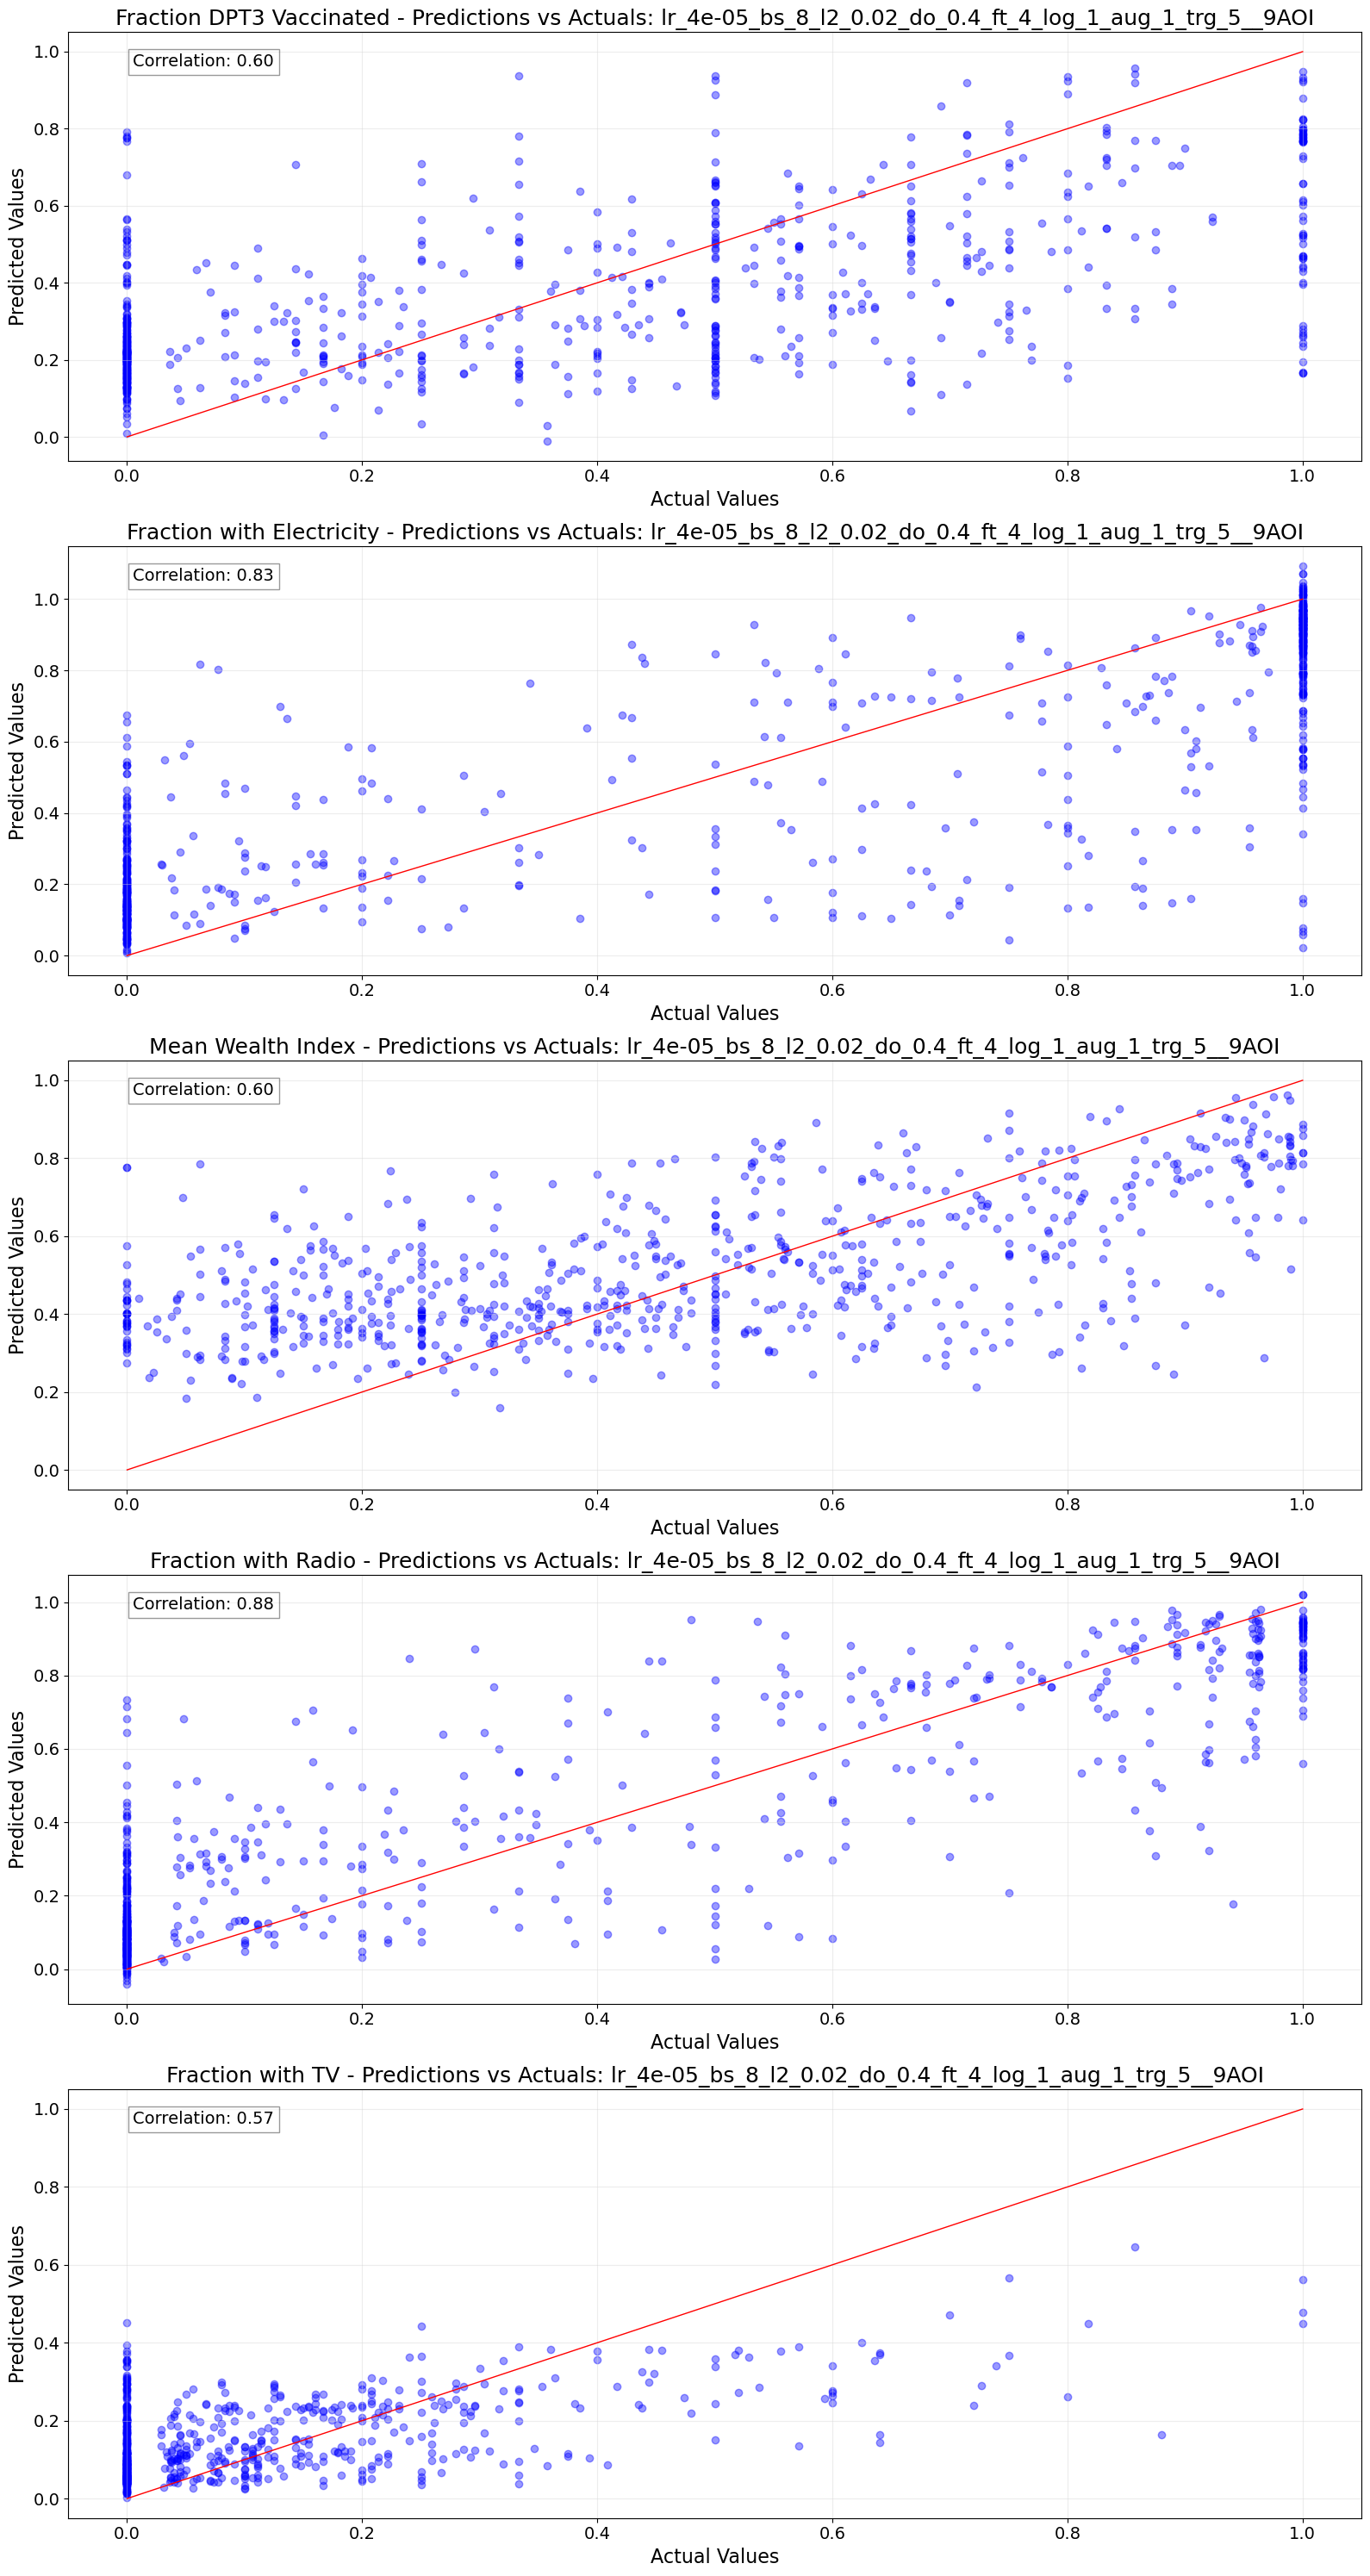

In [29]:
if train_config.MODEL_MODE != ModelMode.PRE_TRAINED:
    
    # Assuming `selected_targets` is a list of target names
    selected_targets = dataset_config.TARGET_TYPE  # List of target names

    titles = [target_name_mapping[target] for target in selected_targets]
    
    out_dir = results_config.PLOT_TRAINING_DIR
    
    case = f'Prediction_{training_string}'
    
    plot_predictions(predictions, 
                     actuals, 
                     out_dir=out_dir,
                     case=case,
                     add_grid=True, 
                     selected_targets=titles, 
                     title_string=training_string)

## ResNet18 Feature Extraction

Process images through the model and extract features.

In [30]:
if train_config.MODEL_MODE != ModelMode.PRE_TRAINED:
    features_resnet, cluster_ids, target_values_list = extract_features(fine_tuned_model, 
                                                                        aoi_data_loader, 
                                                                        features_list,
                                                                        device=DEVICE)
    print("Using Fine-Tuned Model")
else:
    features_resnet, cluster_ids, target_values_list = extract_features(pretrained_model, 
                                                                        aoi_data_loader, 
                                                                        features_list,
                                                                        device=DEVICE)
    print("Using Pre-Trained Model")

Using Fine-Tuned Model


In [31]:
print(features_resnet.shape)
print(len(cluster_ids))

(550, 25088)
550


## Standardize Features

In [32]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features_resnet)
#features_standardized = scaler.fit_transform(features_resnet_pruned)

print(features_standardized.shape)  # Check the shape

(550, 25088)


## Add Geospatial Data

In [33]:
print(f"Value of country_code variable: '{country_code}'")


Value of country_code variable: 'PK'


In [34]:
if results_config.COMPUTE_GEOSPATIAL:
    
    geospatial_df = add_geospatial_image_paths(geospatial_df, dataset_config, country_code)

    print(geospatial_df.head())
    print('Number of records: ',len(geospatial_df))

               lat     lon  fraction_dpt3_vaccinated  \
cluster_id                                             
1           36.450  72.572                     0.667   
2           35.892  71.727                     0.667   
3           35.170  71.834                     0.500   
4           35.425  72.164                     0.333   
5           35.006  71.776                     0.143   

            fraction_with_electricity  fraction_with_fresh_water  \
cluster_id                                                         
1                               1.000                        1.0   
2                               1.000                        1.0   
3                               1.000                        1.0   
4                               0.111                        1.0   
5                               1.000                        0.9   

            mean_wealth_index  fraction_with_radio  fraction_with_tv  \
cluster_id                                                

## Load Raster Data, Compute Statistics, and Store in Data Frame

In [35]:
# Ensure 'country_code' is properly assigned and normalized
country_code = country_code.upper().strip()

geospatial_df = add_geospatial_image_paths(geospatial_df, dataset_config, country_code)


In [36]:
geospatial_df = add_statistics_to_dataframe(geospatial_df, data_types)

# Display the updated DataFrame
print(geospatial_df.head())

cluster_id
1    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
2    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
3    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
4    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
5    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
Name: nightlights_path, dtype: object
cluster_id
1    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
2    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
3    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
4    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
5    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
Name: population_path, dtype: object
cluster_id
1    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
2    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
3    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
4    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
5    ./GIS-Image-Stack-Processing/AOI/PK/Image_Tile...
Name: rainfall_path, dtype: object
               lat     lon  frac

## Feature Projection

In [37]:
def project_umap(features, n_components=2, n_neighbors=15, min_dist=0.1, random_state=42):

    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    projected_data = reducer.fit_transform(features)
    
    return projected_data

In [38]:
class ProjectionType(Enum):
    PCA  = "PCA"
    UMAP = "UMAP"   
    
#----------------------------------------
# *** SET PROJECTION TYPE HERE ***
#----------------------------------------
projection_type = ProjectionType.UMAP
#----------------------------------------

    
if projection_type == ProjectionType.UMAP: # STOP: DO NOT EDIT THIS BY MISTAKE!
       
    projected_features = project_umap(features_standardized, 
                                      n_components=2, 
                                      n_neighbors=15, 
                                      min_dist=0.1)  
else:
    pca = PCA(n_components=10)
    pca.fit(features_standardized)

    # Transform the data
    projected_features = pca.transform(features_standardized)


/Users/billk/miniforge3/envs/py39-pt/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [39]:
print(projected_features.shape)

(550, 2)


In [40]:
case = f'{country_code}_{extraction_layer}_{projection_type.value}_Features_{training_string}'
    
plot_title = f'{country_code}: {projection_type.value} Features [Extraction: {extraction_layer}]'
    
out_dir = results_config.PLOT_UMAP_FEAT_DIR

# Assuming you have UMAP features and cluster IDs
plot_clusters(projected_features, 
              cluster_ids, 
              cluster_colors,
              vaccination_rates=geospatial_df['fraction_dpt3_vaccinated'].values, 
              num_components=2,
              out_dir=out_dir,
              case=case, 
              plot_title=plot_title,
              save_to_disk=True)

Plot saved to ./Plots_Projected_Features/9AOI/PK_layer4_UMAP_Features_lr_4e-05_bs_8_l2_0.02_do_0.4_ft_4_log_1_aug_1_trg_5__9AOI_comp_1_2.png


In [41]:
print(f"all_features shape: {features_standardized.shape}") 
print(projected_features.shape)
print(projection_type.value)

all_features shape: (550, 25088)
(550, 2)
UMAP


## Spectral Clustering

In [42]:
# # Specify the number of clusters (nearest_neighbors, discretize
# n_clusters = 2


# # Initialize and fit Spectral Clustering
# spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',n_neighbors=20, 
#                               assign_labels='kmeans', random_state=42, n_init=30)

# cluster_labels = spectral.fit_predict(features_umap[:, [0, 1]])

## K-Means Clustering (Recomended)

In [43]:
# Default number of clusters based on experimentation. These numbers generally work best for most cases.
aoi_num_clusters = {
    'AM': 3,  # Maybe more
    'MA': 3,
    'MB': 3,  # Maybe more
    'ML': 3,
    'MR': 3, 
    'NI': 5,  # Maybe 4
    'PK': 4,  # Maybe 3
    'SN': 3,  # Maybe 2
    'TD': 3
}

n_clusters = aoi_num_clusters.get(country_code, 0)

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20, max_iter=50)

cluster_labels = kmeans.fit_predict(projected_features[:, [0, 1]])

In [44]:
label_counts = np.bincount(cluster_labels)

for label, count in enumerate(label_counts):
    print(f"Cluster {label}: {count} instances")

Cluster 0: 159 instances
Cluster 1: 159 instances
Cluster 2: 131 instances
Cluster 3: 101 instances


In [45]:
# Now use the updated function to safely assign cluster labels
geospatial_df_copy = assign_cluster_labels_by_matching(geospatial_df, cluster_ids, cluster_labels)


geospatial_df after merging:
             cluster_label
cluster_id               
1                       2
2                       2
3                       1
4                       1
5                       0


## Plot 2D UMAP Clusters

In [46]:
case = f'{country_code}_{extraction_layer}_{projection_type.value}_{n_clusters}Clusters_{training_string}'
plot_title = f'{country_code}: {projection_type.value} Features {model_string}, [Extraction: {extraction_layer}]'
    
    
out_dir = results_config.PLOT_GEOSPATIAL_DIR


# Assuming you have UMAP features and cluster IDs
plot_clusters(projected_features, 
              cluster_labels, 
              cluster_colors,
              vaccination_rates=geospatial_df_copy['fraction_dpt3_vaccinated'].values, 
              out_dir=out_dir,
              case=case, 
              plot_title=plot_title,
              num_components=2, 
              use_distinct_colors=True, 
              save_to_disk=True)

Plot saved to ./Plots_Geospatial/9AOI/PK_layer4_UMAP_4Clusters_lr_4e-05_bs_8_l2_0.02_do_0.4_ft_4_log_1_aug_1_trg_5__9AOI_comp_1_2.png


## Plot Cluster Assignments in Geographical Context

In [47]:
# Prepare data for plotting
geospatial_df_copy['cluster_label_str'] = geospatial_df_copy['cluster_label'].astype(str)
cluster_label_factors = geospatial_df_copy['cluster_label_str'].unique().tolist()

# Convert lat/lon to Mercator coordinates
mercator_x, mercator_y = wgs84_to_mercator(geospatial_df_copy['lon'].values, geospatial_df_copy['lat'].values)

# Build the data dictionary
data_dict = {
    'cluster_id': geospatial_df_copy.index,  # cluster_id is the index
    'lat': geospatial_df_copy['lat'],
    'lon': geospatial_df_copy['lon'],
    'cluster_label': geospatial_df_copy['cluster_label_str'],
    'fraction_dpt3_vaccinated': geospatial_df_copy['fraction_dpt3_vaccinated'],
    'mercator_x': mercator_x,
    'mercator_y': mercator_y
}

# Create the ColumnDataSource
source = ColumnDataSource(data=data_dict)

# Add optional fields if they exist in the dataframe
if 'rainfall_mean' in geospatial_df.columns:
    data_dict['rainfall_mean'] = geospatial_df_copy['rainfall_mean']
if 'population_mean' in geospatial_df.columns:
    data_dict['population_mean'] = geospatial_df_copy['population_mean']
if 'nightlights_mean' in geospatial_df.columns:
    data_dict['nightlights_mean'] = geospatial_df_copy['nightlights_mean']

# Create the ColumnDataSource with the dynamically constructed data_dict
source = ColumnDataSource(data=data_dict)

# Define mandatory tooltips
tooltips = [
    ("Cluster ID", "@cluster_id"),
    ("Latitude", "@lat"),
    ("Longitude", "@lon"),
    ("DPT3 Vaccinated", "@fraction_dpt3_vaccinated{0.0%}"), 
]

# Conditionally add optional tooltips based on available data
if 'rainfall_mean' in data_dict:
    tooltips.append(("Rainfall (mean)", "@rainfall_mean"))
if 'population_mean' in data_dict:
    tooltips.append(("Population (mean)", "@population_mean"))
if 'nightlights_mean' in data_dict:
    tooltips.append(("Nightlights (mean)", "@nightlights_mean"))
    
    

# Count occurrences of each cluster_label and sort them by size
cluster_sizes = {cluster: list(source.data['cluster_label']).count(cluster) for cluster in set(source.data['cluster_label'])}
sorted_clusters = sorted(cluster_sizes, key=cluster_sizes.get, reverse=True)

# Assign the largest cluster to the first color in cluster_colors
sorted_colors = [cluster_colors[i % len(cluster_colors)] for i in range(len(sorted_clusters))]

# Create a mapping from cluster labels to colors
cluster_color_mapping = dict(zip(sorted_clusters, sorted_colors))

# Update the color_spec to use the sorted colors for the cluster labels
color_spec = factor_cmap('cluster_label', palette=[cluster_color_mapping[cluster] for cluster in sorted_clusters] + list(Category10[10]), factors=sorted_clusters)

  
plot_title = f'{country_code}: {projection_type.value} Clusters ({model_string}) [Extraction: {extraction_layer}]'
case = f'{country_code}_{extraction_layer}_{projection_type.value}_{n_clusters}Clusters_Map__{training_string}'

out_dir = results_config.PLOT_GEOSPATIAL_DIR
    
# Continue with the rest of the code to create the plot
create_geospatial_plot(source=source, 
                       tooltips=tooltips, 
                       color_spec=color_spec, 
                       out_dir=out_dir,
                       case=case,
                       plot_title=plot_title,
                       color_bar=False,
                       symbol_size=symbol_size)

# Initialize the data dictionary with mandatory fields
data_dict = {
    'cluster_id': geospatial_df_copy.index,
    'lat': geospatial_df_copy['lat'],
    'lon': geospatial_df_copy['lon'],
    'fraction_dpt3_vaccinated': geospatial_df_copy['fraction_dpt3_vaccinated'],
    'mercator_x': mercator_x,
    'mercator_y': mercator_y
}

# Add optional fields if they exist in the dataframe
if 'rainfall_mean' in geospatial_df_copy.columns:
    data_dict['rainfall_mean'] = geospatial_df_copy['rainfall_mean']
if 'population_mean' in geospatial_df.columns:
    data_dict['population_mean'] = geospatial_df_copy['population_mean']
if 'nightlights_mean' in geospatial_df.columns:
    data_dict['nightlights_mean'] = geospatial_df_copy['nightlights_mean']

# Create the ColumnDataSource with the dynamically constructed data_dict
source = ColumnDataSource(data=data_dict)

# Define mandatory tooltips with percentage format for DPT3 Vaccinated
tooltips = [
    ("Cluster ID", "@cluster_id"),
    ("Latitude", "@lat"),
    ("Longitude", "@lon"),
    ("DPT3 Vaccinated", "@fraction_dpt3_vaccinated{0.0%}")
]

# Conditionally add optional tooltips based on available data
if 'rainfall_mean' in data_dict:
    tooltips.append(("Rainfall (mean)", "@rainfall_mean"))
if 'population_mean' in data_dict:
    tooltips.append(("Population (mean)", "@population_mean"))
if 'nightlights_mean' in data_dict:
    tooltips.append(("Nightlights (mean)", "@nightlights_mean"))



reversed_palette = Viridis256[::-1]
color_mapper = LinearColorMapper(palette=reversed_palette, 
                                  low=min(source.data['fraction_dpt3_vaccinated']), 
                                  high=max(source.data['fraction_dpt3_vaccinated']))

color_spec = {
    'field': 'fraction_dpt3_vaccinated', 
    'transform': color_mapper
}


plot_title = f'{country_code}: Vaccination Coverage'

color_bar_title = "Vaccination Coverage"

out_dir = results_config.PLOT_GEOSPATIAL_DIR

case = f'{country_code}_Vaccination_Coverage'

create_geospatial_plot(source, 
                       tooltips, 
                       color_spec, 
                       out_dir=out_dir,
                       case=case,
                       plot_title=plot_title,
                       color_bar=True, 
                       color_bar_title=color_bar_title,
                       symbol_size=symbol_size)

Plot saved to ./Plots_Geospatial/9AOI/PK_layer4_UMAP_4Clusters_Map__lr_4e-05_bs_8_l2_0.02_do_0.4_ft_4_log_1_aug_1_trg_5__9AOI.png


Plot saved to ./Plots_Geospatial/9AOI/PK_Vaccination_Coverage.png


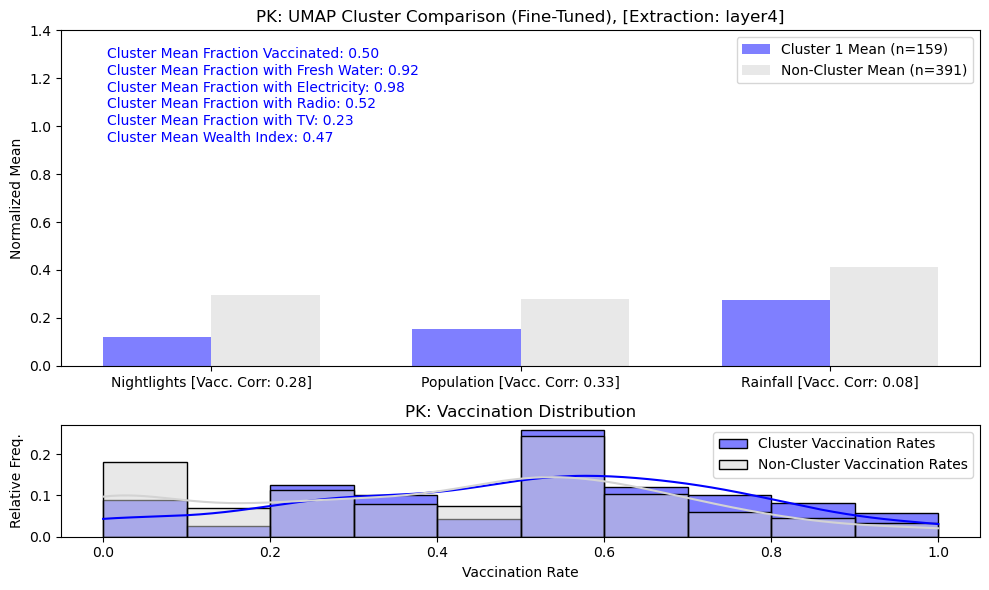

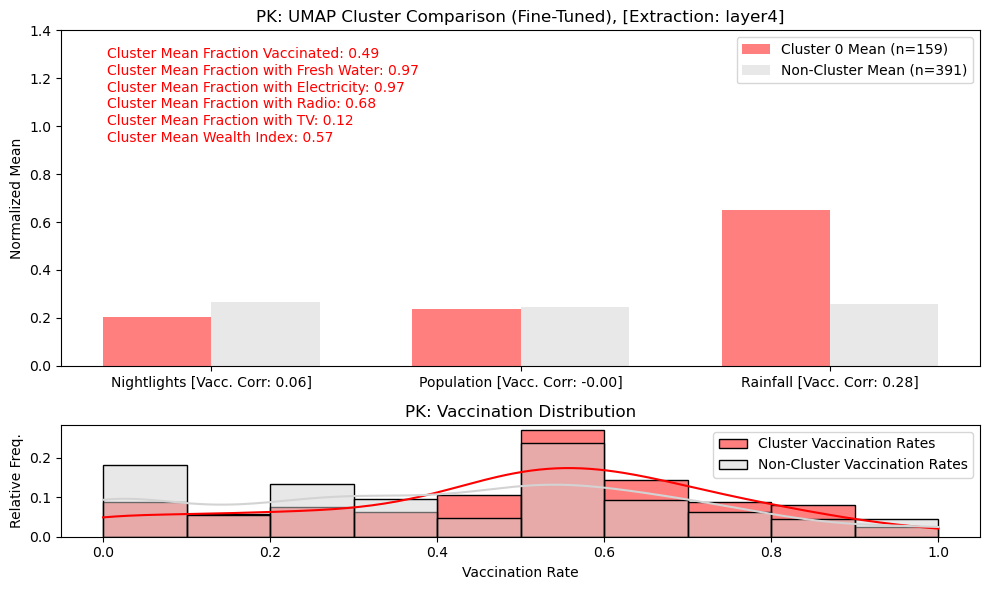

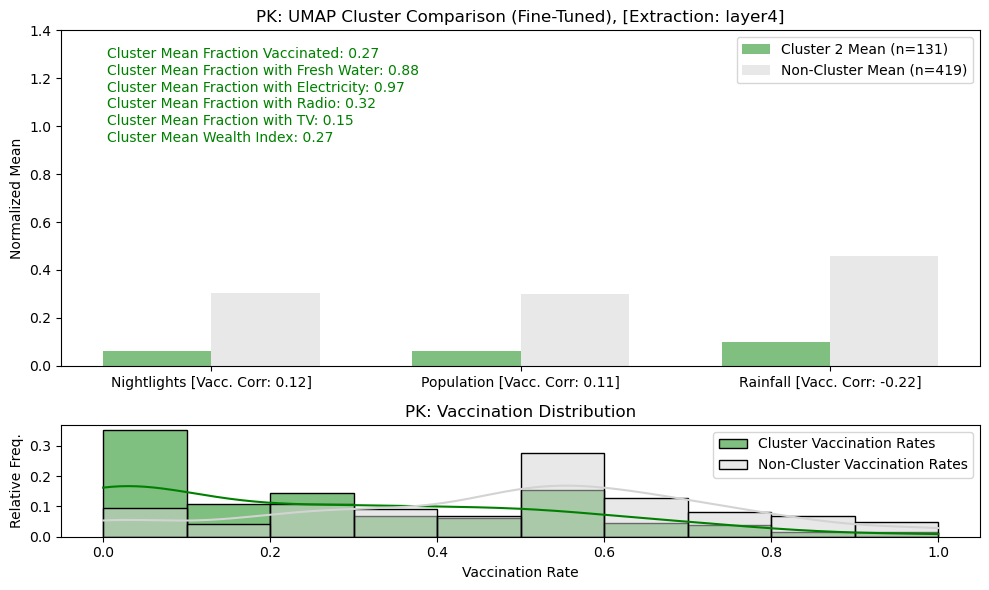

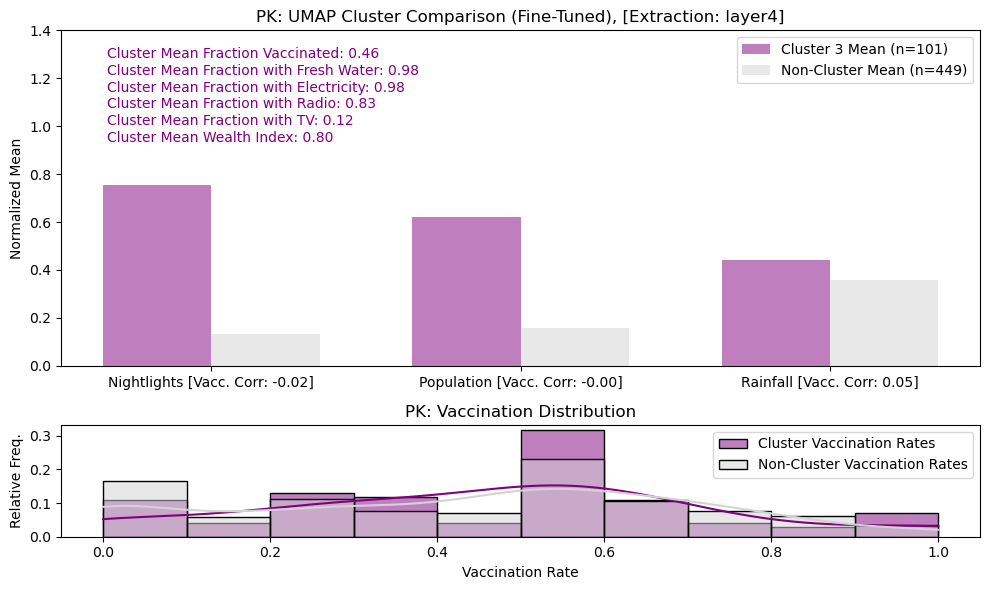

In [48]:
# Get the cluster sizes from the DataFrame
cluster_sizes = geospatial_df_copy['cluster_label'].value_counts()

# Sort clusters by size (largest to smallest)
sorted_clusters = cluster_sizes.index.tolist()  # Sorted list of cluster labels based on size

# Map sorted clusters to colors
color_map = {cluster_label: cluster_colors[i % len(cluster_colors)] for i, cluster_label in enumerate(sorted_clusters)}

# Debug: Check the color assignment to make sure the largest cluster is blue
#print("Cluster size and color mapping:", [(cluster, color_map[cluster]) for cluster in sorted_clusters])

for cluster_label in sorted_clusters:

    # Compute stats and get vaccination rates for cluster and non-cluster
    (cluster_stats, non_cluster_stats, cluster_count, non_cluster_count, 
     unnormalized_cluster_means, unnormalized_non_cluster_means, 
     survey_means_cluster, correlations, 
     cluster_vaccination_rates, non_cluster_vaccination_rates) = compute_cluster_aggregated_statistics_and_correlations(geospatial_df_copy, cluster_label=cluster_label)


    # Get the color for this cluster from the color_map
    cluster_color = color_map[cluster_label]
          
    case = f'{country_code}_{extraction_layer}_{projection_type.value}_{n_clusters}Cluster_Compare_{training_string}_{cluster_label}'
    plot_title = f'{country_code}: {projection_type.value} Cluster Comparison ({model_string}), [Extraction: {extraction_layer}]'
        
    out_dir = results_config.PLOT_GEOSPATIAL_DIR
        
    # Plot the comparison for this cluster with the correct color
    plot_comparison(country_code,
                    cluster_stats, 
                    non_cluster_stats, 
                    cluster_label, 
                    cluster_count=cluster_count, 
                    non_cluster_count=non_cluster_count, 
                    unnormalized_cluster_means=unnormalized_cluster_means, 
                    unnormalized_non_cluster_means=unnormalized_non_cluster_means, 
                    survey_means_cluster=survey_means_cluster, 
                    correlations=correlations, 
                    cluster_vaccination_rates=cluster_vaccination_rates, 
                    non_cluster_vaccination_rates=non_cluster_vaccination_rates,
                    cluster_color=cluster_color, 
                    stats_normalized=True,
                    out_dir=out_dir,
                    case=case,
                    plot_title=plot_title,
                    plot_values=False)
